Code to plot illustration of pixel wise data

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib_scalebar.scalebar import ScaleBar

from src.HolomonitorFunctions import get_pixel_size
from src.Segmentation3D import get_voxel_size_35mm
from src.PlottingUtils import mean_dist, subregion
from src.FormatConversions import import_holomonitor_stack, import_tomocube_stack

In [3]:
# experimental parameters
dt = 4 # h
dt_holo = 12
dt_tomo = 4

pix_to_um = get_pixel_size()
vox_to_um = get_voxel_size_35mm()

In [8]:
holo_dict = json.load(open("../../data/Holomonitor/settings.txt"))
holo_dict

{'files': ['../../data/Holomonitor/MDCK_01.03.2024/B2-5',
  '../../data/Holomonitor/MDCK_19.03.2024/A1-9',
  '../../data/Holomonitor/MDCK_19.03.2024/A1-12',
  '../../data/Holomonitor/MDCK_19.03.2024/A1-18',
  '../../data/Holomonitor/MDCK_19.03.2024/B1-11',
  '../../data/Holomonitor/MDCK_16.05.2024/B1-9',
  '../../data/Holomonitor/MDCK_16.05.2024/A2-1',
  '../../data/Holomonitor/MDCK_16.05.2024/A2-7',
  '../../data/Holomonitor/MDCK_16.05.2024/B1-13',
  '../../data/Holomonitor/MDCK_16.05.2024/B1-22',
  '../../data/Holomonitor/MDCK_16.05.2024/B1-25'],
 'fmin': [188, 1, 1, 130, 1, 1, 1, 1, 1, 1, 1],
 'fmax': [225, 181, 145, 181, 145, 145, 240, 160, 172, 110, 200],
 'blur_factor': 0.75}

In [9]:
tomo_dict = json.load(open("../../data/Tomocube/settings.txt"))
tomo_dict

{'files': ['../../data/Tomocube/MDCK_10.02.2025/A2P1'],
 'fmin': [1],
 'fmax': [40],
 'blur_factor': 0.95}

In [ ]:
# Find correct density
plot_density = 2600 # cells / mm²

# loop through files, take out frame 
holo_frames = []
tomo_frames = []

i = 0
for file, fmin, fmax in zip(holo_dict["files"], holo_dict["fmin"], holo_dict["fmax"]):

    # open dataframe
    df = pd.read_csv(f"{file}/area_volume_unfiltered.csv")

    # compute density and round to nearest 100
    n_cells   = np.array([len(df[df.frame==f]) for f in range(fmax-fmin)])
    A_cells   = np.array([np.sum(df[df.frame==f].A) * pix_to_um[-1]**2 * 1e-6 for f in range(fmax-fmin)])
    densities = np.round(n_cells * 1e-2 / A_cells) * 1e2

    # array of corresponding frames
    frames = np.array([frame for frame in range(fmin, fmax)])

    mask = (densities >= plot_density-100) * (densities <= plot_density+100) 
    holo_frames.append(frames[mask][0:-1:2*dt_holo])
    
    i += 1
    if i > 3:
        break

for file, fmin, fmax in zip(tomo_dict["files"], tomo_dict["fmin"], tomo_dict["fmax"]):

    # open dataframe
    df = pd.read_csv(f"{file}/area_volume_unfiltered.csv")

    # compute density and round to nearest 100
    n_cells   = np.array([len(df[df.frame==f]) for f in range(fmax-fmin)])
    A_cells   = np.array([np.sum(df[df.frame==f].A) * 1e-6 for f in range(fmax-fmin)])
    densities = np.round(n_cells * 1e-2 / A_cells) * 1e2

    # array of corresponding frames
    frames = np.array([frame for frame in range(fmax-fmin)])

    print(len(densities), len(frames))

    mask = (densities >= plot_density-100) * (densities <= plot_density+100)
    tomo_frames.append(frames[mask][0:-1:2*dt_tomo])

39 39


In [10]:
holo_frames = [np.array([188, 212]), np.array([129, 153]), np.array([98]), np.array([172]), np.array([], dtype=np.int64), np.array([109])]
tomo_frames = [[1, 9]]

In [ ]:
# Import Holomonitor

h_holo = []
for i in range(6):
    path   = holo_dict["files"][i]
    frames = holo_frames[i]
    if len(frames) < 1:
        continue
    file  = path.split("/")[-1]
    folder = path.split(file)[0]

    for f in frames:
        h_holo.append(import_holomonitor_stack(folder, file, f_min=f, f_max=f)[0,:977,:977])

h_holo = np.array(h_holo)

In [ ]:
# Import Tomocube

h_tomo = []
n_tomo = []
for path, frames in zip(tomo_dict["files"], tomo_frames):
    if len(frames) < 1:
        continue

    for f in frames:
        n_tmp, h_tmp = import_tomocube_stack(path, "250210.113448.MDCK dynamics.001.MDCK B.A2.T001P01", h_scaling=vox_to_um[0], f_min=f, f_max=f)
        h_tomo.append(h_tmp[0,:3480,:3480])
        n_tomo.append(n_tmp[0,:3480,:3480])

h_tomo = np.array(h_tomo)
n_tomo = np.array(n_tomo)

In [13]:
# compute mean distributions
x_holo,  h_holo_hist, h_holo_err = mean_dist(h_holo, bins=30, hist_range=(0, 20))
x_tomo,  h_tomo_hist, h_tomo_err = mean_dist(h_tomo, bins=22, hist_range=(0, 20))
nx_tomo, n_tomo_hist, n_tomo_err = mean_dist(n_tomo, bins=30, hist_range=(1.365, 1.4))

Array lenght is: 7
Array lenght is: 2
Array lenght is: 2


In [14]:
# compute mean and std
h_holo_mean = np.mean(h_holo[h_holo>0])
h_tomo_mean = np.mean(h_tomo[h_tomo>0])
n_tomo_mean = np.mean(n_tomo[h_tomo>0])

h_holo_std = np.std(h_holo[h_holo>0])
h_tomo_std = np.std(h_tomo[h_tomo>0])
n_tomo_std = np.std(n_tomo[h_tomo>0])

print(f"Holomonitor heights = {h_holo_mean:0.2f}, {h_holo_std:0.2f}")
print(f"Tomocube heights    = {h_tomo_mean:0.2f}, {h_tomo_std:0.2f}")
print(f"Tomocube refractive index = {n_tomo_mean:0.3f}, {n_tomo_std:0.3f}")

Holomonitor heights = 5.91, 2.33
Tomocube heights    = 7.55, 2.60
Tomocube refractive index = 1.380, 0.004


In [15]:
# cut out equal sized region from all data
region_size = 100 # in µm
c_holo = [400, 400]
c_tomo = [1200, 2500]

him_holo = subregion(h_holo[3], c_holo, region_size, pix_to_um)
him_tomo = subregion(h_tomo[0], c_tomo, region_size, vox_to_um)
nim_tomo = subregion(n_tomo[0], c_tomo, region_size, vox_to_um)

In [31]:
lw = 3
color = "darkblue"
sns.set_theme(style='ticks', palette='muted', font_scale=1.1)

# Define the GridSpec layout
width_ratios  = [1, 0.05, 0.25, 1, 0.05, 0.2, 1, 0.05, 0.2]
height_ratios = [1, 0.01, 0.15, 0.25, 0.66]
gs = gridspec.GridSpec(5, 9, width_ratios=width_ratios, height_ratios=height_ratios)
gs.update(wspace=0.2, hspace=0.2)

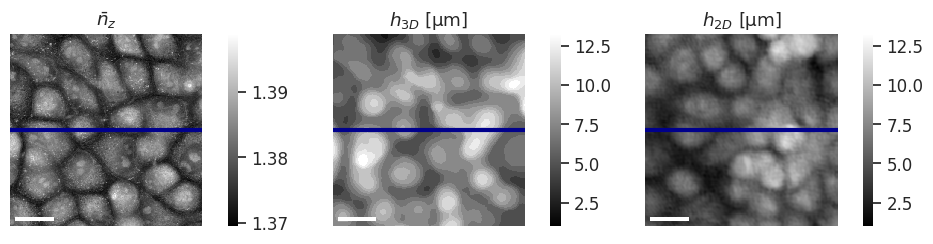

In [32]:
# First row
hmin  = 1
hmax  = np.max([him_holo.max(), him_tomo.max()])
p_idx = 50

fig = plt.figure(figsize=(12, 6))
sns.set_theme(style='ticks', palette='bright', font_scale=1.1)

im2 = fig.add_subplot(gs[0, 0])
im1 = fig.add_subplot(gs[0, 3])
im0 = fig.add_subplot(gs[0, 6])
cb2 = fig.add_subplot(gs[0, 1])
cb1 = fig.add_subplot(gs[0, 4])
cb0 = fig.add_subplot(gs[0, 7])

sns.heatmap(him_holo, ax=im0, square=True, cmap="gray", xticklabels=False, yticklabels=False, cbar_ax=cb0, vmin=hmin, vmax=hmax)
sns.heatmap(him_tomo, ax=im1, square=True, cmap="gray", xticklabels=False, yticklabels=False, cbar_ax=cb1, vmin=hmin, vmax=hmax)
sns.heatmap(nim_tomo, ax=im2, square=True, cmap="gray", xticklabels=False, yticklabels=False, cbar_ax=cb2)

sns.lineplot(x=[0, region_size / pix_to_um[-1]], y=[int(p_idx/pix_to_um[0]), int(p_idx/pix_to_um[0])], ax=im0, lw=lw, color=color)
sns.lineplot(x=[0, region_size / vox_to_um[-1]], y=[int(p_idx/vox_to_um[1]), int(p_idx/vox_to_um[1])], ax=im1, lw=lw, color=color)
sns.lineplot(x=[0, region_size / vox_to_um[-1]], y=[int(p_idx/vox_to_um[1]), int(p_idx/vox_to_um[1])], ax=im2, lw=lw, color=color)

im0.set(title=r"$h_{2D}$ [µm]")
im1.set(title=r"$h_{3D}$ [µm]")
im2.set(title=r"$\bar{n}_z$")

for im, convert in zip([im0, im1, im2], [pix_to_um, vox_to_um, vox_to_um]):
    sb = ScaleBar(convert[-1], 'um', box_alpha=0, color="w", height_fraction=2e-2, scale_loc="none", fixed_value=20)
    sb.location = 'lower left'
    im.add_artist(sb)

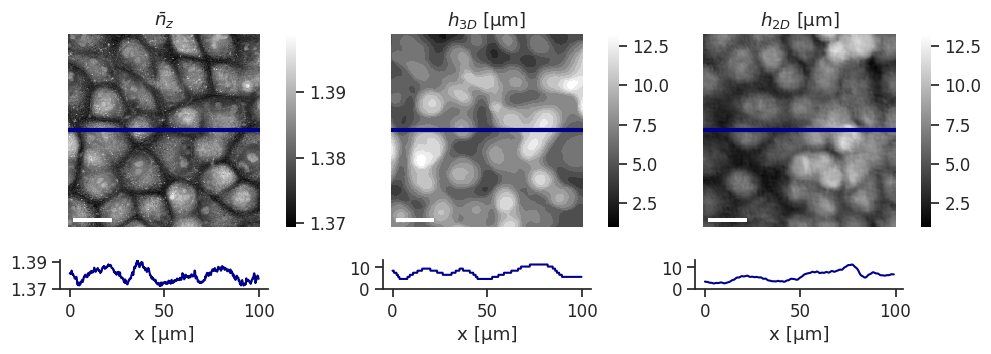

In [33]:
# Second row
p2  = fig.add_subplot(gs[2, 0])
p1  = fig.add_subplot(gs[2, 3])
p0  = fig.add_subplot(gs[2, 6], sharey=p1)

sns.lineplot(x=pix_to_um[0]*np.arange(0, len(him_holo)), y=him_holo[int(p_idx/pix_to_um[0])], ax=p0, color=color)
sns.lineplot(x=vox_to_um[1]*np.arange(0, len(him_tomo)), y=him_tomo[int(p_idx/vox_to_um[1])], ax=p1, color=color)
sns.lineplot(x=vox_to_um[1]*np.arange(0, len(him_tomo)), y=nim_tomo[int(p_idx/vox_to_um[1])], ax=p2, color=color)

sns.despine(ax=p0)
sns.despine(ax=p1)
sns.despine(ax=p2)

p0.set(ylim=(0, hmax))
p2.set(ylim=(1.37,1.391), yticks=[1.37, 1.39])

p0.set(xlabel="x [µm]")
p1.set(xlabel="x [µm]")
p2.set(xlabel="x [µm]")
fig

/tmp/ipykernel_24471/3520498589.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


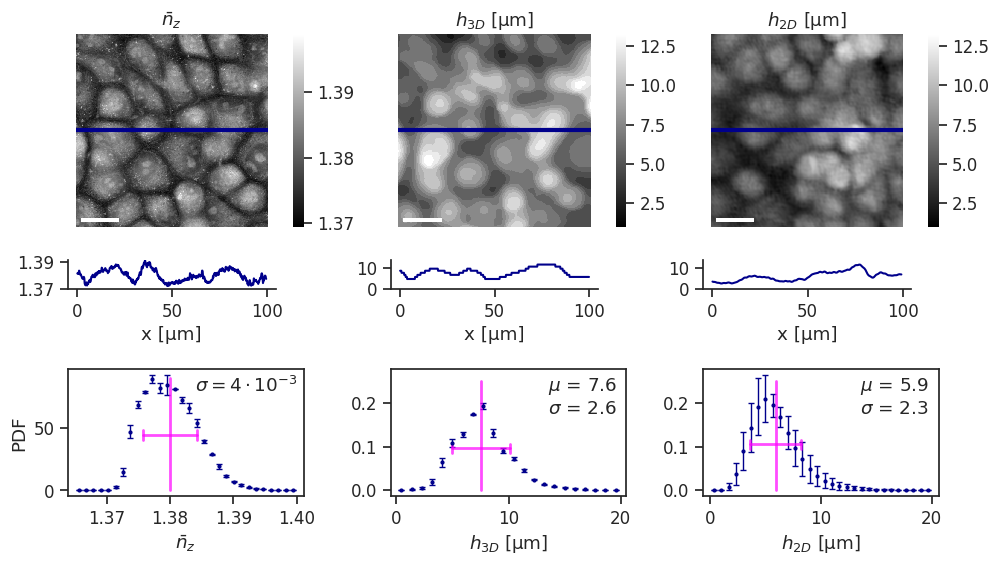

In [34]:
# Third row
h2  = fig.add_subplot(gs[4,0:2])
h1  = fig.add_subplot(gs[4,3:5])
h0  = fig.add_subplot(gs[4,6:8], sharey=h1)

lw = 1
ms = 4
color = "darkblue"

h0.errorbar(x_holo,  h_holo_hist, yerr=h_holo_err, fmt=".", lw=lw, ms=ms, capsize=2, capthick=1, color=color)
h1.errorbar(x_tomo,  h_tomo_hist, yerr=h_tomo_err, fmt=".", lw=lw, ms=ms, capsize=2, capthick=1, color=color)
h2.errorbar(nx_tomo, n_tomo_hist, yerr=n_tomo_err, fmt=".", lw=lw, ms=ms, capsize=2, capthick=1, color=color)

lw = 2
color = "magenta"

h0.plot([h_holo_mean, h_holo_mean], [0,0.25], '-', color=color, lw=lw, alpha=0.7)
h1.plot([h_tomo_mean, h_tomo_mean], [0,0.25], '-', color=color, lw=lw, alpha=0.7)
h2.plot([n_tomo_mean, n_tomo_mean], [0,90],   '-', color=color, lw=lw, alpha=0.7)

h0.set(xlabel=r"$h_{2D}$ [µm]")#, yscale="log")
h1.set(xlabel=r"$h_{3D}$ [µm]")#, yscale="log")
h2.set(ylabel="PDF", xlabel=r"$\bar{n}_z$")#, yscale="log");

fwhm = h_holo_hist.max() / 2
h0.text(13.5, 0.175, f"$\mu$ = {h_holo_mean:0.1f}\n$\sigma$ = {h_holo_std:0.1f}")
h0.plot([h_holo_mean-h_holo_std, h_holo_mean+h_holo_std], [fwhm, fwhm],           lw=lw, color=color, alpha=0.7)
h0.plot([h_holo_mean-h_holo_std, h_holo_mean-h_holo_std], [fwhm-0.01, fwhm+0.01], lw=lw, color=color, alpha=0.7)
h0.plot([h_holo_mean+h_holo_std, h_holo_mean+h_holo_std], [fwhm-0.01, fwhm+0.01], lw=lw, color=color, alpha=0.7)

fwhm = h_tomo_hist.max() / 2
h1.text(13.5, 0.175, f"$\mu$ = {h_tomo_mean:0.1f}\n$\sigma$ = {h_tomo_std:0.1f}")
h1.plot([h_tomo_mean-h_tomo_std, h_tomo_mean+h_tomo_std], [fwhm, fwhm],           lw=lw, color=color, alpha=0.7)
h1.plot([h_tomo_mean-h_tomo_std, h_tomo_mean-h_tomo_std], [fwhm-0.01, fwhm+0.01], lw=lw, color=color, alpha=0.7)
h1.plot([h_tomo_mean+h_tomo_std, h_tomo_mean+h_tomo_std], [fwhm-0.01, fwhm+0.01], lw=lw, color=color, alpha=0.7)

fwhm = n_tomo_hist.max() / 2
h2.text(1.384, 79, rf"$\sigma = 4\cdot10^{{-3}}$")#{n_tomo_std:0.3f}")
h2.plot([n_tomo_mean-n_tomo_std, n_tomo_mean+n_tomo_std], [fwhm, fwhm],           lw=lw, color=color, alpha=0.7)
h2.plot([n_tomo_mean-n_tomo_std, n_tomo_mean-n_tomo_std], [fwhm-4, fwhm+4], lw=lw, color=color, alpha=0.7)
h2.plot([n_tomo_mean+n_tomo_std, n_tomo_mean+n_tomo_std], [fwhm-4, fwhm+4], lw=lw, color=color, alpha=0.7)

# sns.despine(ax=h0)
# sns.despine(ax=h1)
# sns.despine(ax=h2)

fig.tight_layout()
fig

In [35]:
fig.savefig("../../figs/illustrations/pixelwise_illustration.png", bbox_inches='tight', dpi=300)